Name: Twitter Sentiment Analysis

Project Type: Natural Language Processing (NLP)

What is NLP?
creation of computational models that process and understand natural language. These include: making the computer understand the semantic grouping of words (e.g. cat and dog are semantically more similar than cat and spoon), text to speech, language translation and many more

What is Sentiment Analysis?
It is the interpretation and classification of emotions (positive, negative and neutral) within text data using text analysis techniques. Sentiment analysis allows organizations to identify public sentiment towards certain words or topics.

https://www.kaggle.com/code/stoicstatic/twitter-sentiment-analysis-for-beginners/data?select=training.1600000.processed.noemoticon.csv

In [10]:
import re
import pickle
import numpy as np
import pandas as pd

import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import nltk
from nltk.stem import WordNetLemmatizer

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# The dataset being used is the sentiment140 dataset. 
# It contains 1,600,000 tweets extracted using the Twitter API. 
# The tweets have been annotated (0 = Negative, 4 = Positive) and they can be used to detect sentiment.


# Load th dataset
# It contains the following 6 fields:
# 1. sentiment: the polarity of the tweet (0 = negative, 4 = positive)
# 2. ids: The id of the tweet (2087)
# 3. date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
# 4. flag: The query (lyx). If there is no query, then this value is NO_QUERY.
# 5. user: the user that tweeted (robotickilldozr)
# 6. text: the text of the tweet (Lyx is cool)

# Importing the dataset
df_columns = ["sentiment", "ids", "date", "flag", "user", "text"]
df_encoding = "ISO-8859-1"
path = r'Datasets\training.1600000.processed.noemoticon.csv'
df = pd.read_csv(path, encoding=df_encoding, names=df_columns)
df.head()

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [3]:
# As we only need the text and the sentiment, we will drop the other columns
df = df.drop(["ids", "date", "flag", "user"], axis=1)
# Replacing the values to ease understanding.
df['sentiment'] = df['sentiment'].replace(4,1)
df.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


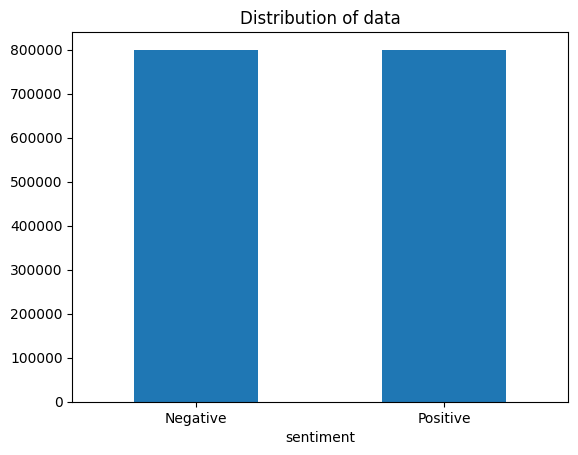

In [4]:
# Plotting the distribution for dataset.
ax = df.groupby('sentiment').count().plot(kind='bar',
                                          title='Distribution of data',
                                          legend=False)

ax.set_xticklabels(['Negative','Positive'], rotation=0)

# Storing data in lists.
text, sentiment = list(df['text']), list(df['sentiment'])

Preprocessing Stage
1. Lower Casing: Each text is converted to lowercase.
2. Replacing URLs: Links starting with "http" or "https" or "www" are replaced by "URL".
3. Replacing Emojis: Replace emojis by using a pre-defined dictionary containing emojis along with their meaning. (eg: ":)" to "EMOJIsmile")
4. Replacing Usernames: Replace @Usernames with word "USER". (eg: "@github" to "USER")
5. Removing Non-Alphabets: Replacing characters except Digits and Alphabets with a space.
6. Removing Consecutive letters: 3 or more consecutive letters are replaced by 2 letters. (eg: "Heyyyy" to "Heyy")
7. Removing Short Words: Words with length less than 2 are removed.
8. Removing Stopwords: Stopwords are the English words which does not add much meaning to a sentence. 
   They can safely be ignored without sacrificing the meaning of the sentence. (eg: "the", "he", "have")
9. Lemmatizing: Lemmatization is the process of converting a word to its base form. (e.g: “Great” to “Good”)

In [6]:
# Emojis that might be present in the tweets
emojis = {':)': 'smile',':-)': 'smile', 
          ';d': 'wink',':-E': 'vampire',
          ':(': 'sad', ':-(': 'sad',
          ':-<': 'sad',':P': 'raspberry',
          ':O': 'surprised',':-@': 'shocked',
          ':@': 'shocked',':-$': 'confused',
          ':\\': 'annoyed', ':#': 'mute',
          ':X': 'mute', ':^)': 'smile',
          ':-&': 'confused','$_$': 'greedy',
          '@@': 'eyeroll',':-!': 'confused',
          ':-D': 'smile',':-0': 'yell',
          'O.o': 'confused','<(-_-)>': 'robot',
          'd[-_-]b': 'dj',":'-)": 'sadsmile',
          ';)': 'wink', ';-)': 'wink',
          'O:-)': 'angel','O*-)': 'angel',
          '(:-D': 'gossip', '=^.^=': 'cat'}

# Stopword in english
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [7]:
def preprocess(data):
    processed_text = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    # Go over every tweet
    for tweet in data:
        
        # 1. Lower case the tweet
        tweet = tweet.lower()
        
        # 2. Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        
        # 3. Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji]) 
            
        # 4. Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet) 
               
        # 5. Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        
        # 6. Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)
        
        tweetwords = ''
        for word in tweet.split():
            # 7, 8. Checking if the word is a stopword.
            # if word not in stopwordlist:
            if len(word)>1:
                # 9. Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processed_text.append(tweetwords)
        
    return processed_text

In [15]:
import time
#nltk.download('wordnet')
#nltk.download('omw-1.4')

t = time.time()
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 180 seconds


In [16]:
# Compare the original text with the processed text
print('Original Text: ', text[0])
print('Processed Text: ', processedtext[0])

Original Text:  @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
Processed Text:  USER URL aww that bummer you shoulda got david carr of third day to do it EMOJIwink 


Visual Analysis Using WordClouds

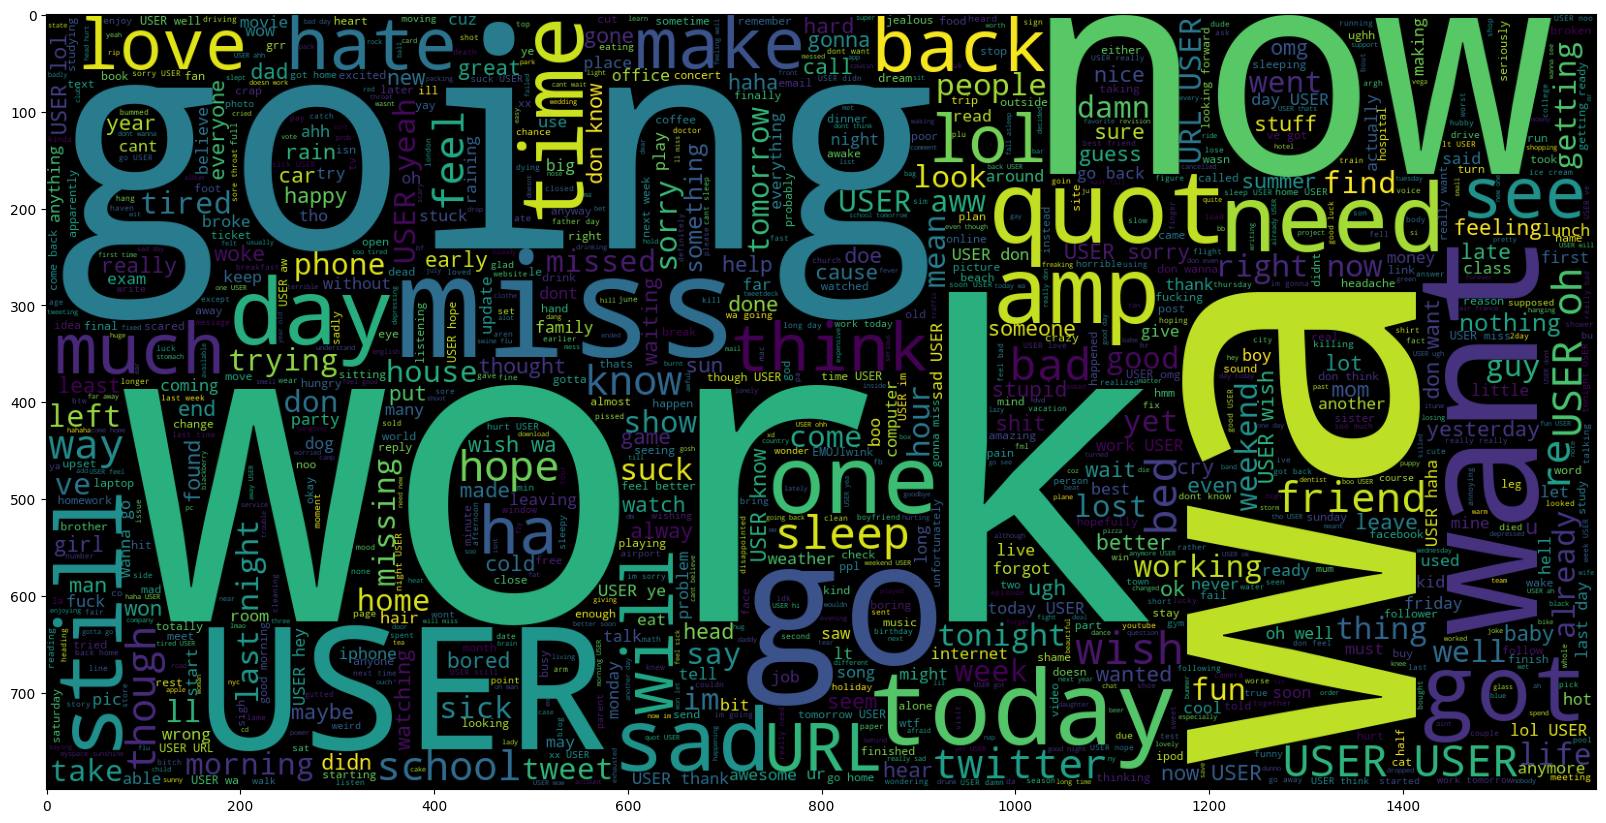

In [60]:
# WordCloud for negative tweets
data_neg = processedtext[:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(
    width=1600, 
    height=800, 
    max_words=2000
    ).generate(" ".join(data_neg))
plt.imshow(wc)

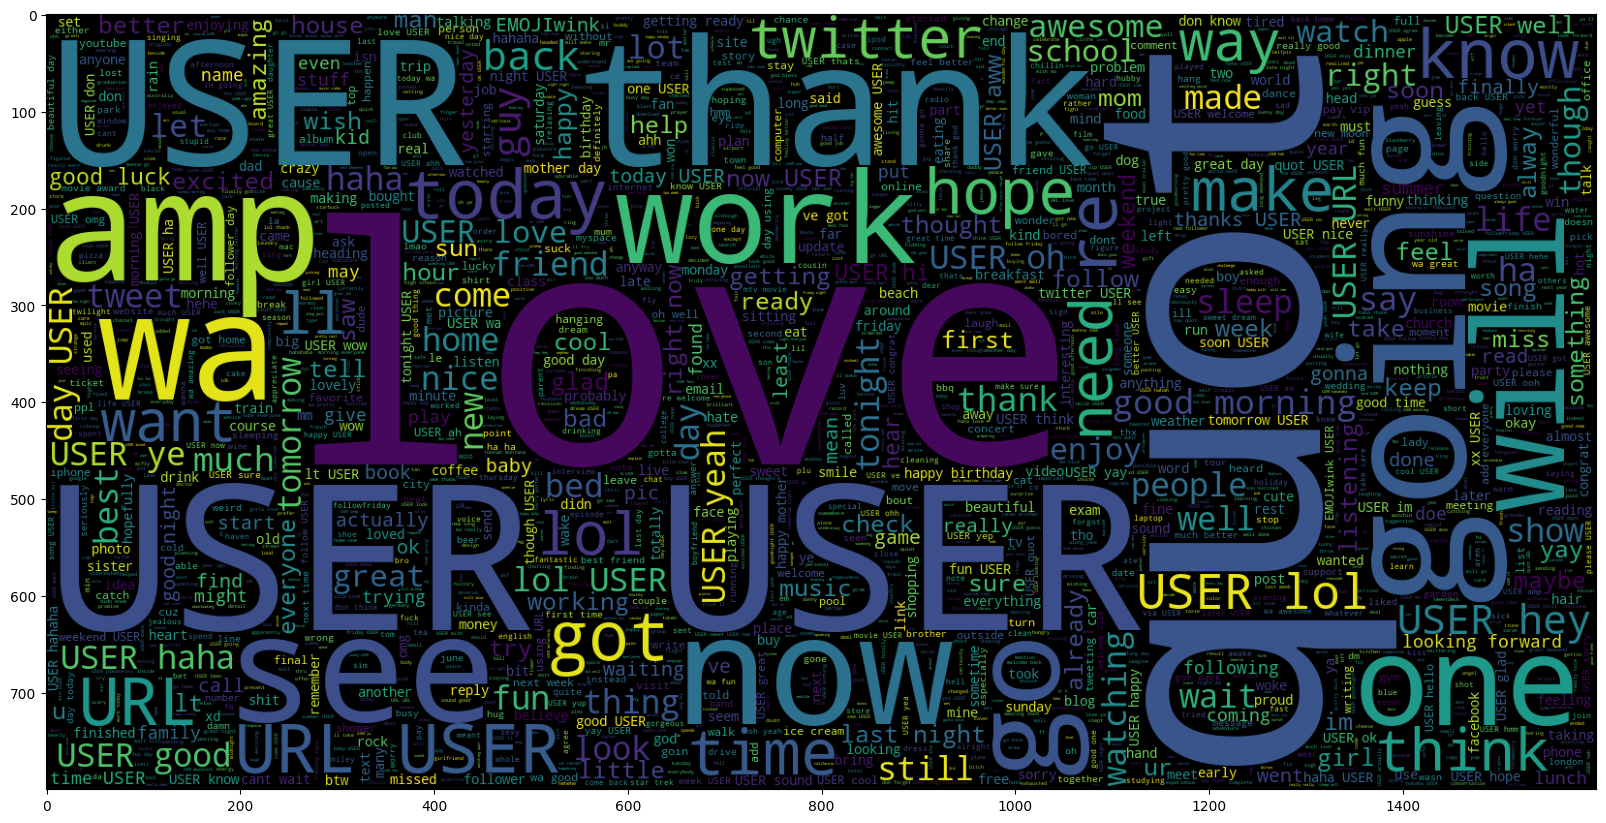

In [70]:
# WordCloud for positive tweets
data_pos = processedtext[800000:]
plt.figure(figsize = (20,20))
wc = WordCloud(
    width=1600, 
    height=800, 
    max_words=2000
    ).generate(" ".join(data_pos))
plt.imshow(wc)
